<a href="https://colab.research.google.com/github/VinayakDGaikwad/MyKerasNotebook/blob/main/Vinayak's_Keras_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
!unzip -q Screenshots.zip
!ls

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "Screenshots",
    validation_split=0.2,
    subset="training",
    seed=1,
    image_size=(720,1440),
    batch_size=1,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "Screenshots",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=(720,1440),
    batch_size=1,
)

Found 11 files belonging to 3 classes.
Using 9 files for training.
Found 11 files belonging to 3 classes.
Using 2 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['WA_Home', 'WA_Menu_Open', 'WA_Settings']


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(1, 720, 1440, 3)
(1,)


In [ ]:
import tensorflow_datasets as tfds

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomZoom(0.1)
    ]
)

augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

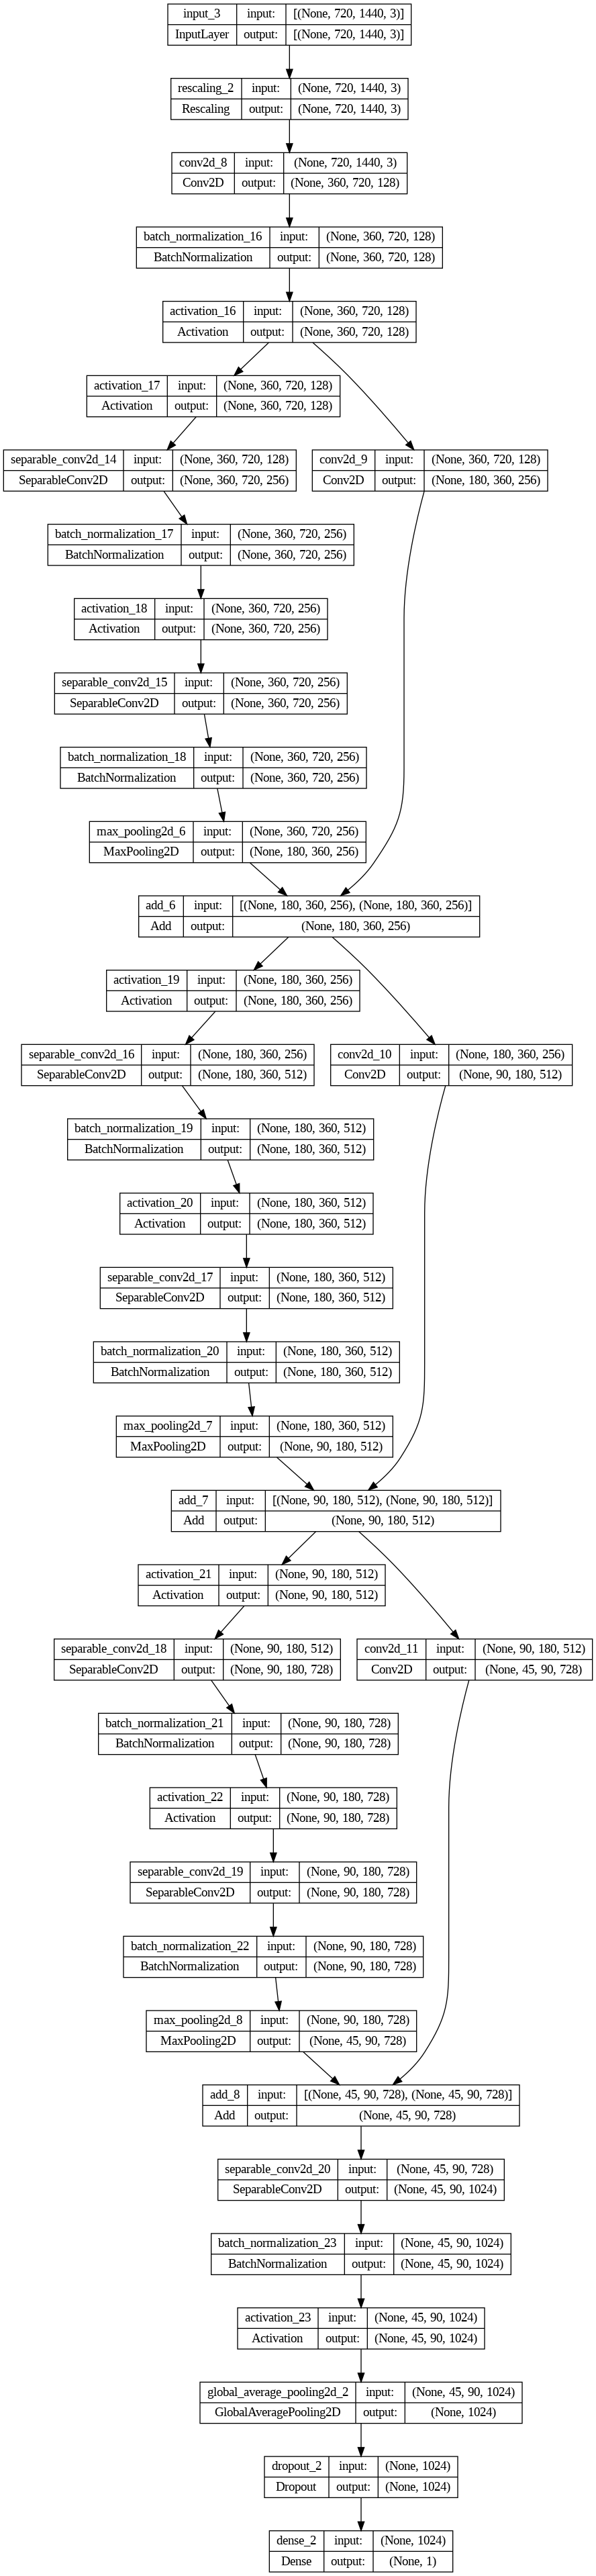

In [ ]:
model = make_model(input_shape=(720,1440) + (3,), num_classes=3)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
9/9 [==============================] - 146s 16s/step - loss: 0.1374 - accuracy: 0.2222 - val_loss: 0.6108 - val_accuracy: 0.0000e+00
Epoch 2/25
9/9 [==============================] - 144s 16s/step - loss: 0.0783 - accuracy: 0.3333 - val_loss: 0.3220 - val_accuracy: 0.0000e+00
Epoch 3/25
9/9 [==============================] - 144s 16s/step - loss: -0.0702 - accuracy: 0.3333 - val_loss: 0.0029 - val_accuracy: 0.0000e+00
Epoch 4/25
9/9 [==============================] - 143s 16s/step - loss: -0.2119 - accuracy: 0.3333 - val_loss: -0.3493 - val_accuracy: 0.0000e+00
Epoch 5/25
9/9 [==============================] - 142s 16s/step - loss: -0.1200 - accuracy: 0.3333 - val_loss: -0.7621 - val_accuracy: 0.0000e+00
Epoch 6/25
9/9 [==============================] - 142s 16s/step - loss: -0.1344 - accuracy: 0.3333 - val_loss: -1.2305 - val_accuracy: 0.0000e+00
Epoch 7/25
9/9 [==============================] - 143s 16s/step - loss: -0.3420 - accuracy: 0.3333 - val_loss: -1.7617 - val_accu